In [1]:
%pylab inline
from astropy.io import fits
import pandas as pd
import glob
import os
import trappist_machine
import scipy.interpolate

Populating the interactive namespace from numpy and matplotlib


In [2]:
# set up file paths - for other users, these will need to be updated!
current_dir = '/Users/jcbecker/Documents/GitHub/trappist1/'
assorteddata = '/Users/jcbecker/Documents/GitHub/trappist1/AssortedData/'
extraFigures = '/Users/jcbecker/Documents/GitHub/trappist1/ExtraFigures/'
paperFigures = '/Users/jcbecker/Documents/GitHub/trappist1/PaperFigures/'

# set up other variables to save time
regen_Q_values = False # if true, re-create the file used for the k/Q constraints. 

# Import data

The orbital parameters used in this analysis come from [Grimm et al. 2018](https://www.aanda.org/articles/aa/full_html/2018/05/aa32233-17/T3.html). We won't be running Monte Carlo sims over the errors this time, so we will import the best fit values of each parameter. 



In [3]:
## trappist system data
trappist1 = pd.read_csv(assorteddata + "trappist_system_properties.csv") # from Grimm+ 2018
trappist1


,Planet,Mass(Mearth),Radius(Rjup),Period(days),a(AU),e,i(deg)
0,TRAPPIST-1 h,0.086,0.06740,18.767953,0.06300,0.00567,89.80
1,TRAPPIST-1 g,0.566,0.10050,12.354473,0.04510,0.00208,89.71
2,TRAPPIST-1 f,0.360,0.09323,9.205585,0.03710,0.01007,89.68
3,TRAPPIST-1 e,0.240,0.08190,6.099043,0.02817,0.00510,89.86
4,TRAPPIST-1 d,0.330,0.06890,4.049959,0.02144,0.00837,89.75
5,TRAPPIST-1 c,1.630,0.09421,2.421807,0.01521,0.00654,89.67
6,TRAPPIST-1 b,0.790,0.09689,1.510876,0.01111,0.00622,89.65


In [4]:
# define global truths about TRAPPIST-1

dist = 12.1 # parsecs
Rearth_to_Mjup = 0.08911498 # 1 earth radii is 0.08 Rjup
trappist_lum = 0.000522 #solar luminosity, used value is bolometric. Visual luminosity is 0.00000373 L_sun. 
solar_lum = 3.848 * 10**33.0 # erg/sec
mstar = 0.089 # solar masses


# Plotting the lightcurve (UVOT)
The 300 ks of SWIFT data is split into epochs at which the data was taken, and a flux estimate or upper limit is derived using heasoft software XSelect at each of those epochs. 

In [5]:
manual_lc = pd.read_csv(assorteddata + "manual_LC.csv")
manual_lc['newtime_start'] = 51910 + (manual_lc['time_start'] ) / (60.* 60. *24.) # convert time to JD, since time units in SWIFT headers is funny.
manual_lc['newtime_end'] = 51910 + (manual_lc['time_end'] ) / (60.* 60. *24.)


In [6]:
# print table for the paper. The latex printout can be copy&pasted into the .tex draft. 
# If more data is added, rerun this and replace table in paper. 
print_cols = ['obs_ID', 'newtime_start', 'newtime_end','count']
manual_lc.sort_values('obs_ID')[print_cols].to_latex(index = False)

u'\\begin{tabular}{rrrr}\n\\toprule\n     obs\\_ID &  newtime\\_start &   newtime\\_end &   count \\\\\n\\midrule\n 10283001.0 &   58010.348779 &  58010.772233 &  0.0200 \\\\\n 10283002.0 &   58095.975270 &  58096.984039 &  0.0220 \\\\\n 10283003.0 &   58097.648316 &  58097.718778 &  0.0200 \\\\\n 10283004.0 &   58103.413035 &  58103.811122 &  0.0180 \\\\\n 10283005.0 &   58105.003031 &  58105.010428 &  0.0230 \\\\\n 10283006.0 &   58113.704544 &  58113.986122 &  0.0230 \\\\\n 10283007.0 &   58114.700832 &  58114.852095 &  0.0150 \\\\\n 10283008.0 &   58117.955622 &  58118.306262 &  0.0120 \\\\\n 10283009.0 &   58124.928569 &  58125.000012 &  0.0240 \\\\\n 10283010.0 &   58126.323775 &  58126.405568 &  0.0200 \\\\\n 10283011.0 &   58131.504108 &  58131.843762 &  0.0210 \\\\\n 10283012.0 &   58133.164500 &  58133.298580 &  0.0260 \\\\\n 10283013.0 &   58136.635220 &  58136.957650 &  0.0410 \\\\\n 10283014.0 &   58236.915500 &  58236.994455 &  0.0240 \\\\\n 10283015.0 &   58237.506675 & 

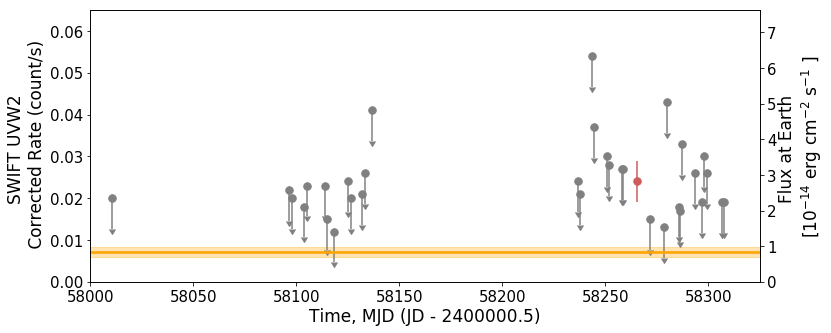

In [7]:
# Plot the lightcurve for the paper

idx = (manual_lc['detection_type'] != 'SUM') & pd.isnull(manual_lc['counterr']) & pd.notnull(manual_lc['count'])
idx_witherrs = (manual_lc['detection_type'] != 'SUM') & pd.notnull(manual_lc['counterr']) & pd.notnull(manual_lc['count'])

time_centers = np.true_divide(manual_lc.loc[idx]['time_end'].values - manual_lc.loc[idx]['time_start'].values, 2)
idx2 = manual_lc['detection_type'] == 'SUM'


xarr_sec = manual_lc.loc[idx]['time_start'].values + time_centers 
xarr = 51910 + (xarr_sec) / (60.* 60. *24.) # the 51910 figure is from: https://swift.gsfc.nasa.gov/analysis/suppl_uguide/time_guide.html
xarr_err = time_centers / (60.* 60. *24.)
yarr = manual_lc.loc[idx]['count'].values
figsize(12,5)
fig, ax1 = subplots()
ax1.errorbar(xarr, yarr, xerr = xarr_err,
         yerr = [np.mean(yarr)*0.3] * len(yarr), 
         uplims = 1, marker='.', color='grey', markersize = 15,linestyle = 'None')
ax1.plot(np.linspace(58000, 58325, 10), 
     [manual_lc.loc[idx2]['count'].values[0]] * 10, linewidth=2.6, color='Orange')
ax1.fill_between(np.linspace(58000, 58325, 10), 
             [manual_lc.loc[idx2]['count'].values[0] - manual_lc.loc[idx2]['counterr'].values[0]] * 10,
             [manual_lc.loc[idx2]['count'].values[0] + manual_lc.loc[idx2]['counterr'].values[0]] * 10,
             color='Orange', alpha=0.3)

#
#
time_centers = np.true_divide(manual_lc.loc[idx_witherrs]['time_end'].values - manual_lc.loc[idx_witherrs]['time_start'].values, 2)
xarr_sec = manual_lc.loc[idx_witherrs]['time_start'].values + time_centers 
xarr = 51910 + (xarr_sec) / (60.* 60. *24.)
xarr_err = time_centers / (60.* 60. *24.)
yarr = manual_lc.loc[idx_witherrs]['count'].values
yarr_err = manual_lc.loc[idx_witherrs]['counterr'].values
ax1.errorbar(xarr, yarr, xerr = xarr_err,
         yerr = yarr_err, 
        marker='.', color='IndianRed', markersize = 15,linestyle = 'None')
#
#
#

ax1.set_xlim(58000, 58325)
ax1.set_ylabel("SWIFT UVW2 \n Corrected Rate (count/s)", fontsize=17)
ax1.set_xlabel("Time, MJD (JD - 2400000.5)", fontsize=17) #MJD not BJD - see SWIFT website above

# make the limits and second axis
ylimz = [0, 0.065] # these will be the limits in count/sec for both y-axes. Set it once to make sure they both match. 
ax1.set_ylim(ylimz) # Left y-axis. 
xticks(fontsize=15)
yticks(fontsize=15)
ax2 = ax1.twinx()
ax2.set_ylim(np.multiply(ylimz, 5.77* 2033 / 100)) # right y-axis
ax2.set_ylabel("Flux at Earth \n[10$^{-14}$ erg cm$^{-2}$ s$^{-1}$ ]", fontsize=17)
xticks(fontsize=15)
yticks(fontsize=15)
savefig(paperFigures + "lcdata_bestfit_mag.png", dpi=100, bbox_inches = 'tight')




# Filter responses / normalization factor
We are using relationships that have been derived for the GALEX NUV band. The SWIFT UVW2 band is similar, but not the same. Let's just check and look at how different the various NUV/FUV/UV filters are. The [filter profiles](http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=Swift/UVOT.UVW2&&mode=browse&gname=Swift&gname2=UVOT#filter) can be found online at the mission's document pages. I estimated the normalizations from published instrument papers. 

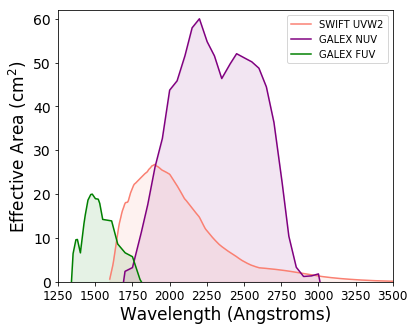

In [8]:
uvw2_rsf = pd.read_csv(assorteddata + "Swift_UVOT.UVW2.dat", names = ['wavelength', 'eff_area_cm2'], delim_whitespace=True)
galex_nuv = pd.read_csv(assorteddata + "GALEX_GALEX.NUV.dat", names = ['wavelength', 'eff_area_cm2'], delim_whitespace=True)
galex_fuv = pd.read_csv(assorteddata + "GALEX_GALEX.FUV.dat", names = ['wavelength', 'eff_area_cm2'], delim_whitespace=True)
galex_vega = 4.531e-9 #(erg/cm2/s/A)
uvw2_vega = 5.237e-9 #(erg/cm2/s/A)
galex_fuv_vega =6.491e-9

# filter profiles: 
# http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=Swift/UVOT.UVW2&&mode=browse&gname=Swift&gname2=UVOT#filter
# the coefficients 20 and 60 correct the file approximately to match with the effective area definitions I found in
# the instrumentation documentation. This is not exact, but it's pretty close, and this plot is just illustrative anyway..

figsize(6,5)
fill_between(galex_nuv['wavelength'], 60 * galex_nuv['eff_area_cm2'] / np.max(galex_nuv['eff_area_cm2'] ) , color='Purple', alpha=0.1)
fill_between(uvw2_rsf['wavelength'], uvw2_rsf['eff_area_cm2'] ,  color='Salmon', alpha = 0.1)
plot(uvw2_rsf['wavelength'], uvw2_rsf['eff_area_cm2'] , label="SWIFT UVW2", color='Salmon')
plot(galex_nuv['wavelength'], 60 * galex_nuv['eff_area_cm2'] / np.max(galex_nuv['eff_area_cm2'] ) , label="GALEX NUV", color='Purple')
galex_eff_ar = 60 * galex_nuv['eff_area_cm2'] / np.max(galex_nuv['eff_area_cm2'] )
fill_between(galex_fuv['wavelength'], 20 * galex_fuv['eff_area_cm2'] / np.max(galex_fuv['eff_area_cm2']),  color='Green', alpha = 0.1)
plot(galex_fuv['wavelength'], 20 * galex_fuv['eff_area_cm2']/ np.max(galex_fuv['eff_area_cm2']), label="GALEX FUV", color='Green')
swift_eff_ar = uvw2_rsf['eff_area_cm2']
xlabel("Wavelength (Angstroms)", fontsize=17)
ylabel("Effective Area (cm$^{2}$)", fontsize=17)
ylim(0,62)
xlim(1250, 3500)
legend()
xticks(fontsize=12)
yticks(fontsize=14)
savefig(extraFigures + "filter_response_comparison.png", dpi=100, bbox_inches = 'tight')


In [9]:
countrate = manual_lc.loc[idx2]['count'].values[0] 
counterr = manual_lc.loc[idx2]['counterr'].values[0]
convfactor = 5.77 # Brown 2016 multiply by count rate to give the flux density in units of 10−16 erg s−1 cm−2 Å−1 - this (5.77) was the value Edmund suggested
fit_val = countrate * convfactor * 10**-16*  2033. #correct for the width of the waveband - I got this value (2033) from Edmund
fiterr = counterr * 5.77 * 10**-16*  2033.

# X-ray data: SWIFT XRT

At first, I thought this data was terrible, but it's actually not. This data requires stacking to get a reliable flux estimate, but we do have one if we stack the entire 300 ks. Edmund did this reduction, and here are his files:

combined_evt.fits – the full events list for the combined XRT data (can be opened as an image, but each event is tagged with time, energy, and position).

trappist_full_xrt_lc.fits – the light curve for the source region (columns include: time bin, count rate, error, and fractional exposure). The light curve was binned to 5000 s and the fractional exposure is the fraction of 5000 s covered by any one bin.

bkg_full_xrt_lc.fits – the light curve for the background region

bkg.reg, xmm.reg – the region files in ds9 format.

Then, we also have: output.lc, created using lcmath and the two \*fits light curves described above. 

This data was taken in event mode (each photon hit is recorded as an event), so we will bin the data into 5000 second chunks instead of using the epochs that we used for the UVOT exposures (which were integrated over the exposure times). 

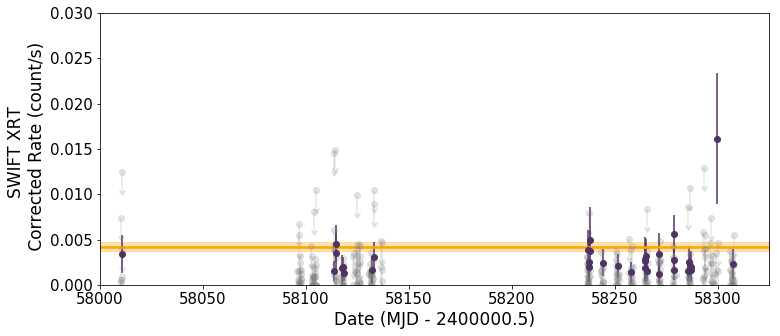

In [17]:
lcdata = fits.open(assorteddata + "SWIFT_XRT/output.lc") # read in background subtracted LC
bkgdata = fits.open(assorteddata + "SWIFT_XRT/bkg_full_xrt_lc.fits") # read in background subtracted LC

# format time column:
lc_x = 51910 + 5.270701373846318E+08 / (60.* 60. *24.) + np.true_divide(np.add(0, zip(*lcdata[1].data)[0]),60.* 60. *24.)
lc_y = zip(*lcdata[1].data)[1]
lc_er = zip(*lcdata[1].data)[2]
lc_ff = zip(*lcdata[1].data)[3]
xrt_lc = pd.DataFrame({'time':lc_x,'flux':lc_y,'error': lc_er, 'filling_factor': lc_ff})
solid_detection = (xrt_lc['flux'] - xrt_lc['error']) > 0
xrt_lc['detect'] = solid_detection
xrt_lc['back_level']= zip(*bkgdata[1].data)[1]
assert zip(*bkgdata[1].data)[0] == zip(*lcdata[1].data)[0] # source and background should have same time array; stop if not

detection_type = []
err = []
true_flux = []
for item in xrt_lc.index: 
    if xrt_lc.iloc[item]['flux'] < 0: #if less than background, we do not have reliable detection, so repalce value with upper limit set at background level. 
                                    # We already subtracted background using lcmath, so less than 0 means 'less than background' here.  
        true_flux.append(xrt_lc.iloc[item]['back_level'])
        detection_type.append('upper_limit')
        err.append(NaN)
    elif (xrt_lc.iloc[item]['flux'] - xrt_lc.iloc[item]['error']) <= 0: # then, this data point is indistinguishable from zero. Also upper limit. 
        true_flux.append(xrt_lc.iloc[item]['flux'])
        detection_type.append('upper_limit')
        err.append(NaN)
    else:
        true_flux.append(xrt_lc.iloc[item]['flux'])
        detection_type.append('detection')
        err.append(xrt_lc.iloc[item]['error'])

xrt_lc['xrt_flux'] = true_flux
xrt_lc['detection_type'] = detection_type
xrt_lc['xrt_error'] = err

xrt_lc.to_csv("AssortedData/SWIFT_XRT/xray_lightcurve_processed.csv") # save this# default - don't include totally empty bins
idxnull  = (xrt_lc['filling_factor'] > 0.0)
##
idx_upplim = idxnull & (xrt_lc['detection_type'] =='upper_limit')
figsize(12,5)
fig, ax1 = subplots()
ax1.errorbar(xrt_lc.loc[idx_upplim]['time'], xrt_lc.loc[idx_upplim]['xrt_flux'], alpha = 0.2, uplims = [1] * len(xrt_lc.loc[idx_upplim]['xrt_flux']), yerr = [0.002] * len(xrt_lc.loc[idx_upplim]['xrt_flux']), color='grey',marker='o',linestyle='None')
idx_detect = idxnull &(xrt_lc['detection_type'] =='detection') # points with detections only
ax1.errorbar(xrt_lc.loc[idx_detect]['time'], xrt_lc.loc[idx_detect]['xrt_flux'], yerr = xrt_lc.loc[idx_detect]['xrt_error'], color='#4F3360',marker='o',linestyle='None')
ax1.set_ylim(0, 30e-3)
ax1.plot(np.linspace(58000, 58325, 10), 
     [0.0042] * 10, linewidth=2.6, color='Orange')
ax1.fill_between(np.linspace(58000, 58325, 10), 
             [0.0042 - 0.0005] * 10,
             [0.0042 + 0.0005] * 10,
             color='Orange', alpha=0.3)
ax1.set_ylabel("SWIFT XRT \n Corrected Rate (count/s)", fontsize=17)
ax1.set_xlabel("Date (MJD - 2400000.5)", fontsize=17)
xticks(fontsize=15)
yticks(fontsize=15)
ax1.set_xlim(58000, 58325)
savefig(paperFigures + "lcdata_xray_subtracted.png", dpi=100, bbox_inches = 'tight')



The photon count estimate (0.0042 counts/sec $\pm$ 0.0005 counts/sec) comes from the stacked 300 ks exposure (and can be computed in XSPEC). To convert that to a flux, we need to make assumptions about the spectrum shape. 

Edmund suggested this online tool: https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/w3pimms/w3pimms.pl to convert the count rate into a flux. We use the 'Swift/XRT/PC count rate' option since this data was collected in Photon Collecting mode. The energy input range runs from 0.3 keV to 10 keV (put that in manually). We put in a nH column density, then choose a model for the spectrum. 

We chose APEC (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node134.html) as the model. 
[APEC](https://iopscience.iop.org/article/10.1086/322992/pdf) calculates emissivities for a hot, diffuse, optically thin plasma that is in collisionally-ionized equiliubrium. These are the conditions in the stellar corona creating the observed X-ray flux, so we choose the log(Temperature) we expect for the M8 to be 

The exact temperature we use for the corona temperature changes the count rate to flux conversion. Using the parameters described above as well as our computed count rate and error on the count rate, we compute an x-ray flux of 


# Convert UV uvw2 flux to Xray and EUV flux, then compute the XUV flux. 
Here we are using the empirical scaling relations from a collection of literature papers. 

Originally, I had to convert UV->X-ray->EUV, but since we have a reliable estimate of the average X-ray flux now, I can use that vaue (which comes from the online calculator) directly. I will also do the extrapolation from UV to X-ray, just to check what it is and how good the empirical models in the literature are. The models in the literature use mostly much more massive stars than M8Vs, so it's likely that they won't be 'that' good. 

In [325]:
print "Uvw2 flux level:", fit_val
fit_valnew = fit_val
print "GALEX NUV est.:", 2.5 * fit_val
dist_to_surf = 5.627e-4# AU
dist_to_earth = 12.1 * 206265 # AU
uv_at_surface = fit_valnew / np.power(dist_to_surf/dist_to_earth,2)
uv_at_surfacemin = (fit_valnew - fiterr) / np.power(dist_to_surf/dist_to_earth,2)
uv_at_surfacemax = (fit_valnew + fiterr) / np.power(dist_to_surf/dist_to_earth,2)
#print log{F_{NUV}} =\log{F_{UV,\texttt{UVW2}}}= 0.36 + 0.83 \log{F_{X}},
xrayfluxsurf = np.power(10, (np.log10(uv_at_surface) - 0.36) / 0.83) 
xrayfluxminsurf = np.power(10, (np.log10(uv_at_surfacemin) - 0.36) / 0.83) 
xrayfluxmaxsurf = np.power(10, (np.log10(uv_at_surfacemax) - 0.36) / 0.83)

print "flux at surface of star in UV (NUV)", uv_at_surface
print "      log(F_uv, surf) = ", np.log10(uv_at_surface)
print "flux at surface of star in xray", xrayfluxsurf
print "      log(F_xray, surf) = ", np.log10(xrayfluxsurf)
print " "
print " ----- Flux from earth: "

## xray
uv_at_earth = uv_at_surface / np.power(dist_to_earth / dist_to_surf,2)
xray_at_earth = xrayfluxsurf / np.power(dist_to_earth / dist_to_surf,2)
xray_at_earthmin = xrayfluxminsurf / np.power(dist_to_earth / dist_to_surf,2)
xray_at_earthmax = xrayfluxmaxsurf / np.power(dist_to_earth / dist_to_surf,2)

uvw2lum = trappist_machine.flux_to_lum(fit_valnew, 12.1) # parsecs
uvw2lumlow = trappist_machine.flux_to_lum(fit_valnew - fiterr, 12.1)
uvw2lumup = trappist_machine.flux_to_lum(fit_valnew + fiterr, 12.1)

print "uv flux level from earth:", uv_at_earth 
print "xray flux level from earth:", xray_at_earth 
print " "
print " -----  Luminosities: "
xraylum = trappist_machine.flux_to_lum(xray_at_earth, 12.1)
xraylummin = trappist_machine.flux_to_lum(xray_at_earthmin, 12.1)
xraylummax = trappist_machine.flux_to_lum(xray_at_earthmax, 12.1)

print "xray luminosity (cgs): %e" % xraylum
print "log xray luminosity (cgs): %f" % np.log10(xraylum)
print "xray fractional luminosity (Lx/Lbol): %e" % (xraylum /  ( solar_lum* trappist_lum))

xsurfmw = xrayfluxsurf
euv_over_Fx  = 425 * (xsurfmw)**-0.42 # this is euv/Fx

## EUV WITHOUT SCALING
euvlum = trappist_machine.flux_to_lum(euv_over_Fx * xrayfluxsurf / np.power(dist_to_earth / dist_to_surf,2), 12.1)
euvlummin = trappist_machine.flux_to_lum(euv_over_Fx * xrayfluxminsurf / np.power(dist_to_earth / dist_to_surf,2), 12.1)
euvlummax = trappist_machine.flux_to_lum(euv_over_Fx * xrayfluxmaxsurf / np.power(dist_to_earth / dist_to_surf,2), 12.1)

print  " "
print " ----- EUV values:"
print "euv luminosity level:", euvlum
print "euv flux level:", trappist_machine.planet_flux(euvlum, 12.1 * 206265)
print "euv fractional luminosity:: %e" % (  euvlum /  ( solar_lum* trappist_lum))

print " ----- "
print "xray flux level (converted back):", trappist_machine.planet_flux(xraylum, 12.1 * 206265) #AU
print "xuv luminosity level (sum):", euvlum + xraylum #AU
print "xuv fractional luminosity: %e" % ((euvlum + xraylum) /  ( solar_lum* trappist_lum))


print " ----- "
print " USING REAL XRAY FLUX "
print " ----- "
res_xrayflux_direct = np.true_divide([xray_at_earthmin, xray_at_earth, xray_at_earthmax], 3)
res_xraylum_fraction_direct = np.true_divide(trappist_machine.flux_to_lum([res_xrayflux_direct, res_xrayflux_direct, res_xrayflux_direct],12.1),   ( solar_lum* trappist_lum))
xray_direct_at_surface = res_xrayflux_direct[1] / np.power(dist_to_surf/dist_to_earth,2)
euv_over_Fx  = 425 * (xray_direct_at_surface)**-0.42 # this is euv/Fx, fixed for measured value

# EUV with true measured xray flux
euvlum = trappist_machine.flux_to_lum(euv_over_Fx * res_xrayflux_direct[1], 12.1)
euvlummin = trappist_machine.flux_to_lum(euv_over_Fx * res_xrayflux_direct[0], 12.1)
euvlummax = trappist_machine.flux_to_lum(euv_over_Fx * res_xrayflux_direct[2], 12.1)

# also x-ray, again:
xraylum_direct = trappist_machine.flux_to_lum(res_xrayflux_direct[1], 12.1)
xraylummin_direct = trappist_machine.flux_to_lum(res_xrayflux_direct[0], 12.1)
xraylummax_direct = trappist_machine.flux_to_lum(res_xrayflux_direct[2], 12.1)

## finally the sum:
xuvmiddle = euvlum + xraylum_direct
xuvmax = euvlummax + xraylummax_direct
xuvmin = euvlummin +xraylummin_direct




Uvw2 flux level: 8.4458952e-15
GALEX NUV est.: 2.1114738e-14
flux at surface of star in UV (NUV) 166155.1017816221
      log(F_uv, surf) =  5.220513680803354
flux at surface of star in xray 717861.3631279216
      log(F_xray, surf) =  5.8560405792811485
 
 ----- Flux from earth: 
uv flux level from earth: 8.4458952e-15
xray flux level from earth: 3.648989273333392e-14
 
 -----  Luminosities: 
xray luminosity (cgs): 6.393594e+26
log xray luminosity (cgs): 26.805745
xray fractional luminosity (Lx/Lbol): 3.183021e-04
 
 ----- EUV values:
euv luminosity level: 9.431850787287512e+26
euv flux level: 5.384781157373279e-14
euv fractional luminosity:: 4.695603e-04
 ----- 
xray flux level (converted back): 3.6501958844378465e-14
xuv luminosity level (sum): 1.582544449522251e+27
xuv fractional luminosity: 7.878624e-04
 ----- 
 USING REAL XRAY FLUX 
 ----- 


In [327]:
# get the values for the table AND their errors. This can be copy pasted into the stellar parameters table in the paper. 
res_xrayflux = [xray_at_earthmin, xray_at_earth, xray_at_earthmax]

res_xraylum_fraction = np.true_divide(trappist_machine.flux_to_lum([xray_at_earthmin, xray_at_earth, xray_at_earthmax],12.1),   ( solar_lum* trappist_lum))
print "$F_{UV, uvw2, Earth}$  & %0.1e $\pm %0.1e$  & This Work \\\ " % (fit_val,fiterr)
print "$L_{UV, uvw2}$ / L$_{*}$  & %0.1e $\pm %0.1e $  & This Work \\\ " % ( uvw2lum/  ( solar_lum* trappist_lum),  (uvw2lumup - uvw2lum)/  ( solar_lum* trappist_lum))
print "$L_{X}$ / L$_{*}$  & %0.1e $^{+%0.1e}_{%0.1e}$  & This Work, extrapolated$ \\\ " % (xraylum/ ( solar_lum* trappist_lum), (xraylummax - xraylum)/ ( solar_lum* trappist_lum), (xraylum - xraylummin) / ( solar_lum* trappist_lum))
print "$L_{X}$ / L$_{*}$  & %0.1e $^{+%0.1e}_{%0.1e}$  & This Work, measured$ \\\ " % (xraylum_direct/ ( solar_lum* trappist_lum), (xraylummax_direct - xraylum_direct)/ ( solar_lum* trappist_lum), (xraylum_direct - xraylummin_direct) / ( solar_lum* trappist_lum))
print "$F_{X}$  & %0.1e $^{+%0.1e}_{%0.1e}$ & This Work, measured \\\ " % (res_xrayflux_direct[1], res_xrayflux_direct[2], res_xrayflux_direct[0])
print "$L_{EUV}$ / L$_{*}$  & %0.1e $^{+%0.1e}_{%0.1e}$   & This Work, extrapolated \\\ " % ( euvlum/  ( solar_lum* trappist_lum),  (euvlummax - euvlum)/  ( solar_lum* trappist_lum), (euvlummin - euvlum)/  ( solar_lum* trappist_lum))
print "$F_{EUV}$  & %0.1e $^{+%0.1e}_{%0.1e}$   & This Work, extrapolated \\\ " % (trappist_machine.planet_flux(euvlum, 12.1 * 206265), trappist_machine.planet_flux(euvlummax, 12.1 * 206265), trappist_machine.planet_flux(euvlummin, 12.1 * 206265))
print "$L_{XUV}$ / L$_{*}$  & %0.1e $^{+%0.1e}_{-%0.1e}$  & This Work, extrapolated \\\ " % ((xuvmiddle) /  ( solar_lum* trappist_lum), (xuvmax - xuvmiddle) /  ( solar_lum* trappist_lum), (xuvmiddle-xuvmin) /  ( solar_lum* trappist_lum))



$F_{UV, uvw2, Earth}$  & 8.4e-15 $\pm 1.4e-15$  & This Work \\ 
$L_{UV, uvw2}$ / L$_{*}$  & 7.4e-05 $\pm 1.2e-05 $  & This Work \\ 
$L_{X}$ / L$_{*}$  & 3.2e-04 $^{+6.5e-05}_{6.3e-05}$  & This Work, extrapolated$ \\ 
$L_{X}$ / L$_{*}$  & 1.1e-04 $^{+2.2e-05}_{2.1e-05}$  & This Work, measured$ \\ 
$F_{X}$  & 1.2e-14 $^{+1.5e-14}_{9.8e-15}$ & This Work, measured \\ 
$L_{EUV}$ / L$_{*}$  & 2.5e-04 $^{+5.1e-05}_{-4.9e-05}$   & This Work, extrapolated \\ 
$F_{EUV}$  & 2.8e-14 $^{+3.4e-14}_{2.3e-14}$   & This Work, extrapolated \\ 
$L_{XUV}$ / L$_{*}$  & 3.5e-04 $^{+7.2e-05}_{-7.0e-05}$  & This Work, extrapolated \\ 


So, we find that the measured value of the x-ray flux is a factor of a few lower than the extrapolated value. The extrapolations are right in line with the Wheatley+ estimates, but our measured values are a bit lower (despite the fact we seem to have caught at least one flare in our time series, which could be biasing us even higher depending on how frequent flares actually are). 

Does this matter? Let's check how it affects the mass loss rates and the ocean retention.

In [322]:
flux_xuv_average = trappist_machine.planet_flux(euvlum + xraylum, trappist1['a(AU)'].values)
flux_xuv_average
trappist1['XUV_flux(erg,cm-2,s-1)'] = flux_xuv_average
# get the mass loss rates, put it in the pandas planet frame
flux_scaled = trappist1['XUV_flux(erg,cm-2,s-1)'] #this needs to be scaled
G = 6.674*10**(-8.0) # cm3g−1s−2
eta = 0.2 # 10-20 percent for low mass planets; Owen & Alvarez 2016
alpha = 1 #planet cross section increases in the UV , less important for cooler planets
K = 1
mdot = (eta * np.pi * flux_scaled * alpha**2.0 * (np.multiply(trappist1['Radius(Rjup)'],1.0) * 6.9911*10**9.0 )**3.0) / \
            (G * 5.9721986*10**27.0 * np.multiply(trappist1['Mass(Mearth)'], 317.828) * K)# eq 1 of Wheatley 
    
trappist1['mass_loss(g/s)'] = mdot # create mass loss column of table


In [304]:
trappist1

,Planet,Mass(Mearth),Radius(Rjup),Period(days),a(AU),e,i(deg),"XUV_flux(erg,cm-2,s-1)",mass_loss(g/s)
0,TRAPPIST-1 h,0.086,0.06740,18.767953,0.06300,0.00567,89.80,141.797240,8.555646e+05
1,TRAPPIST-1 g,0.566,0.10050,12.354473,0.04510,0.00208,89.71,276.691484,8.409717e+05
2,TRAPPIST-1 f,0.360,0.09323,9.205585,0.03710,0.01007,89.68,408.884885,1.559802e+06
3,TRAPPIST-1 e,0.240,0.08190,6.099043,0.02817,0.00510,89.86,709.210542,2.751183e+06
4,TRAPPIST-1 d,0.330,0.06890,4.049959,0.02144,0.00837,89.75,1224.332320,2.056586e+06
5,TRAPPIST-1 c,1.630,0.09421,2.421807,0.01521,0.00654,89.67,2432.710604,2.114938e+06
6,TRAPPIST-1 b,0.790,0.09689,1.510876,0.01111,0.00622,89.65,4559.537147,8.896811e+06


In [305]:
# solve optimization problem:
# n-body sims stabilty (ecc damping), mass loss rates, tidal Qs, system age
# we will leave this for a future work 

# Tidal Q Analysis

The planets' orbits will evolve The magnitude of these effects can be estimated using the following expression from Goldreich 1963 (with expressions written in a functionally identical form to that used in Barnes 2008):
\begin{equation}
da/dt = \Big( \frac{-63}{2}\frac{1}{Q' m_p}  \sqrt{GM^3} r_p^5 e^2 + \frac{9}{2}\frac{\sigma}{Q_{*}'}  \sqrt{G/M} R^5 m_{p} \Big) a^{-11/2},
\end{equation}
where $Q' = 3Q / 2k_{2}$, $m_p$ denotes a planetary mass, $r_p$ denotes a planetary radius, $G$ is the gravitational constant, $M$ denotes the stellar mass, $R$ the stellar radius, $a$ denotes the planetary semi-major axis, $e$  the planetary eccentricity, and the term $\sigma = sign(2\Omega - 3n)$ (where $\Omega$ is the stellar spin rate and $n$ the planetary mean motion) described the relative frequencies of the stellar rotational period and planetary orbital period. 
In Gillon 2016, the TRAPPIST-1 rotation rate was estimated using ground-based data to be $P_{rot}= 1.40$ days, but follow-up work using data from the K2 spacecraft (Luger 2017, Vida 207) provided an updated value of $P_{rot}= 3.3$ days, which we use in this analysis. 
This value of $P_{rot}= 3.3$ days (giving the star a rotational period situated in between the orbital periods of planets c and d) means that the sign term $\sigma$ cannot be neglected, as different planets will be affected differently by tides raised on the star. 

Without a non-zero eccentricity, the orbital energy will not significantly change, and so $a$ will not change.
A secondary paired equation can be written to describe the evolution of eccentricity over time \citep{Goldreich1963},
\begin{equation}
de/dt = \Big(\frac{-63}{4}\frac{1}{Q' m_p}  \sqrt{GM^3} r_p^5 + \frac{171}{16}\frac{\sigma}{Q_{*}'}  \sqrt{G/M} R^5 m_{p} \Big) e\ a^{-13/2},
\end{equation}
where the first term is due to tides raised on the planet and the second term is due to tides raised on the star. 

Also, we need an expression for the mass loss rate (Luger et al. 2015, Bourrier et al. 2017):
\begin{equation}
    \dot{m_p} = \epsilon ( r_{XUV} / r_p )^{2} ( 3 F_{XUV} / 4 G \rho K )
    \label{eq:mdot}
\end{equation}
where $\epsilon$ is the heating efficiency, $r_p$ the true radius of the planet, $r_{XUV}$ the effective planetary radius in the XUV waveband, $F_{XUV}$ the XUV flux received by the planet, $G$ the gravitational constant, and $K$ is a tidal enhancement factor, where:
\begin{equation}
    K = 1 - \frac{3}{2} \frac{r_{XUV}}{r_{roche}} +  \frac{1}{2}\frac{r_{XUV}^{2}}{r_{roche}^2}
\end{equation}
where $r_{roche}$ is the planetary Roche Lobe ($r_{roche}~=~(m_p / 2 M_{*})^{1/3} a$). 

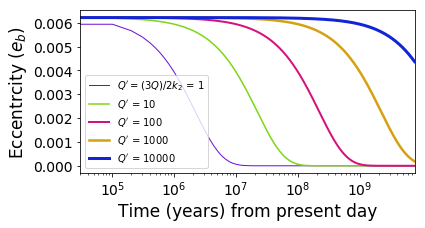

In [306]:
from scipy.integrate import odeint, ode

perz = np.copy(trappist1['Period(days)'].values)
perz.sort()
color_to_use = ['#6a11d6','#7dd611','#d6117d','#d6a111','#1125d6']
linez = [1,1.5,2,2.5,3] #line widths for plotting to make it color-blind accessible 
y0 = [0.011,0.00622, 0.00270 * 330.0] # initial conditions at y0
t = np.linspace(0, 1.01e10, 100000)
abserr = 1.0e-10
relerr = 1.0e-8
dmdtval = trappist1.loc[trappist1['Planet'] == 'TRAPPIST-1 b']['mass_loss(g/s)'].values[0] * 5.2804674*10**(-21.)

figsize(6,3)
for i, qval in enumerate(np.true_divide([1,10,100, 1000, 10000], 5.)):
    sol = odeint(trappist_machine.tidal_evo, y0, t, args = (qval,1e-5, perz[0], dmdtval), atol=abserr, rtol=relerr)
    asol,esol,msol = zip(*sol)
    if i == 0:
        plot(t, esol, label = r"$Q' = (3 Q) / 2 k_{2}$ = %i" % (3. * qval / (2 * 0.3)), linewidth=linez[i], color=color_to_use[i])
    else:
        plot(t, esol, label = r"$Q'$ = %i" % (3. * qval / (2 * 0.3)), color=color_to_use[i], linewidth=linez[i])
legend()
#ylim(0.0108,0.0115)
xlabel("Time (years) from present day", fontsize=17)
#xlabel("3/2 * Q/k", fontsize=17)
ylabel("Eccentrcity ($e_b$)", fontsize=17)
xticks(fontsize=14)
yticks(fontsize=14)
xlim(3e4, 7.6e9)
xscale("log")
savefig(paperFigures + "trappist-ecc.png", dpi=150, bbox_inches = 'tight')

#  DE/DT DA/DT DL/DT
What happens to the eccentricity of the planets as the orbits evolve, according to a simple tidal model? This can also be computed using the timescale expression and not the full time-series. 

If we increase $dm/dt$ enough, it will start to change the solutions: for $de/dt$, this can even mean that the tide raised on the star becomes less and less important than the tide raised on the planet. However, the expected values of $dm/dt$ for this system are really too small to matter, and the imbalance between the sizes of the two terms if already extreme because $Q_{*}$ is so large. 

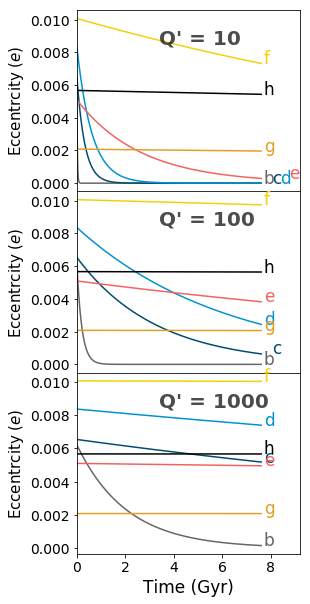

In [316]:
# make e plot with all planets
# don't forget to make things radians. and convert back at the end. 
t = np.linspace(0, 7.6e9, 100000)
#integrate it
from scipy.integrate import odeint, ode
abserr = 1.0e-10
relerr = 1.0e-8

colors_for_this = ["#666666","#004C70","#0093D1","#F2635F","#F4D00C","#E0A025","k"]
## first look at planet b alone, its future evolution from this current point. 

#
figsize(4,10)
qvals = [10./5.,100./5., 1000./5]
for knum in range(len(qvals)):
    subplot(len(qvals), 1,knum +1)
    counter =0
    for i, planet in enumerate(['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d','TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g', 'TRAPPIST-1 h']):
        sma = trappist1.loc[trappist1['Planet'] == planet]['a(AU)'].values[0]
        ecc = trappist1.loc[trappist1['Planet'] == planet]['e'].values[0]
        mass = trappist1.loc[trappist1['Planet'] == planet]['Mass(Mearth)'].values[0] 
        per = trappist1.loc[trappist1['Planet'] == planet]['Period(days)'].values[0] 
        dmdtval = trappist1.loc[trappist1['Planet'] == planet]['mass_loss(g/s)'].values[0] * 5.2804674*10**(-21.) #convert units
        y0 = [sma, ecc, mass] # initial conditions at y0
        sol = odeint(trappist_machine.tidal_evo, y0, t, args = (qvals[knum],1e-5,per, dmdtval), atol=abserr, rtol=relerr) # solve this
        asol,esol,msol = zip(*sol)
        plot(t /1e9, esol, label = "%s" % planet, color=colors_for_this[i])
        if esol[-1] < 0.001: # add text labels so we know which planet is which if seen without color
            text(7.7 + counter * 0.35,esol[-1], planet[-1], color = colors_for_this[i], fontsize=17)
            counter = counter + 1
        else:
            text(7.7,esol[-1], planet[-1], color = colors_for_this[i], fontsize=17)

    if knum != len(qvals) -1:
        xticks([],[],fontsize=14)
        yticks(fontsize=14)
    xlim(0,9.2)
    text(3.4,0.0085, "Q' = %i" % (3. * qvals[knum] / (0.3 * 2)), fontweight = 'bold', fontsize=20, alpha=0.7)
    ylabel("Eccentrcity ($e$)", fontsize=15)
xticks(fontsize=14)
subplots_adjust(hspace = 0)
xlabel("Time (Gyr)", fontsize=17)
yticks(fontsize=14)
savefig(paperFigures + "trappist-all-ecc-pumpedn_botherms.png", dpi=150, bbox_inches = 'tight')

# Find the values of k/Q that keep eccentricites non-zero over system age. 
This cell takes a little while to run (on the order of ~30 minutes), so the results will also be saved as "timescale_plot_data.pkl" and can be loaded rather than re-generated. We note that since $dm/dt$ is small, the derived timescales should not vary compared to the classic analytic expression; however, we solve the ODE in anticipation that for systems with larger $dm/dt$, the changing planetary mass could matter over long time scales. 

In [17]:
# don't forget to make things radians. and convert back at the end. 
t = np.linspace(0, 10e9, 1000000)

colors_for_this = ["#666666","#004C70","#0093D1","#F2635F","#F4D00C","#E0A025","k"]

#
figsize(4,10)
qvals = np.logspace(-1, 4, 60)
answers = pd.DataFrame()
endtimes = pd.DataFrame()

# using the errors from the Grimm paper, find the place that we couldn't see if the result is incompatable with zero or not:
incomp_with_zero = [0.00622 - 2 * 0.00304, 0.00654 - 3 * 0.00188, 0.00837 - 8* 0.00093, 0.00510 - 8* 0.00058, 0.01007 - 7* 0.00068, 
                    0.00208 - 3* 0.00058, 0.00567 - 4 * 0.00121] # comes from errors on each measured value of the ecc
if regen_Q_values ==True:
    for knum in range(len(qvals)):
        tmpz =[]
        timez = []
        for i, planet in enumerate(['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d','TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g', 'TRAPPIST-1 h']):
            sma = trappist1.loc[trappist1['Planet'] == planet]['a(AU)'].values[0]
            ecc = trappist1.loc[trappist1['Planet'] == planet]['e'].values[0]
            mass = trappist1.loc[trappist1['Planet'] == planet]['Mass(Mearth)'].values[0] 
            per = trappist1.loc[trappist1['Planet'] == planet]['Period(days)'].values[0] 
            dmdtval = trappist1.loc[trappist1['Planet'] == planet]['mass_loss(g/s)'].values[0] * 5.2804674*10**(-21.) #convert units

            y0 = [sma, ecc, mass] # initial conditions at y0
            sol = odeint(trappist_machine.tidal_evo, y0, t, args = (qvals[knum],1e-5,per, dmdtval), atol=abserr, rtol=relerr)
            asol,esol,msol = zip(*sol)
            tmpz.append(esol[-1])
            try:
                timeend = min(pd.Series(t).loc[pd.Series(esol) < (incomp_with_zero[i])])
            except ValueError:
                timeend = NaN
            timez.append(timeend)

        answers = answers.append({'mean': np.mean(tmpz), 'b':tmpz[0],'c':tmpz[1], 'd':tmpz[2], 
                                 'e':tmpz[3], 'f':tmpz[4], 'g':tmpz[5], 'h':tmpz[6],
                                  'btime':timez[0],'ctime':timez[1], 'dtime':timez[2], 
                                 'etime':timez[3], 'ftime':timez[4], 'gtime':timez[5], 'htime':timez[6],
                                 'q': qvals[knum]}, ignore_index=True)



In [18]:
if regen_Q_values ==True:
    answers['k/Q'] =0.3 / answers['q']
    answers.to_pickle(assorteddata + "timescale_plot_data.pkl") # save results

In [19]:
answers = pd.read_pickle(assorteddata + "timescale_plot_data.pkl") # shortcut to make plot without generating results

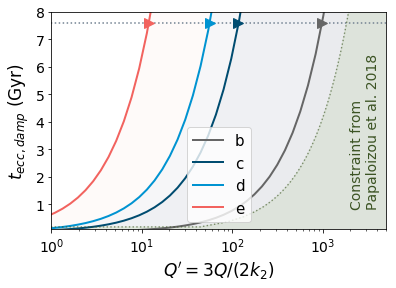

In [20]:
figsize(6,4)
colors_for_this = ["#666666","#004C70","#0093D1","#F2635F","#F4D00C","#E0A025","k"]

for i, plano in enumerate(['b','c','d','e']):
    x = 3/2. * 1./answers['k/Q']
    plot(x, answers[plano +'time'] /1e9, color=colors_for_this[i], linewidth = 2, label=plano)
    fill_between(np.append(x.values, 10000), np.append((answers[plano +'time'].fillna(10e9).values/1e9),10), color= colors_for_this[i], alpha=0.03)

ytimes = np.linspace(0,9)
pap_est = 1.2*10**3*(ytimes/5)
fill_between(np.append(pap_est, 10000), np.append(ytimes,10), color= '#458B00', alpha=0.08)
plot(pap_est, ytimes, '#3B5323', linewidth=1.4,linestyle=":", alpha=0.6)
hlines(7.6, 0, 5000, 'SlateGrey', linestyle=":")
xscale('log')
xlim(1, 5e3)
ylim(0.1, 8)
xticks(fontsize=14)
yticks(fontsize=14)
xlabel("$Q' = 3 Q / (2 k_{2})$", fontsize=17)
ylabel("$t_{ecc, damp}$ (Gyr)", fontsize=17)


# the arrows are added manually at the intersection point between curve and 7.6 Gyr line


endt = [1200, 116, 58, 12] # initial guesses
for i, plano in enumerate(['b','c','d','e']):
    x = 3/2. * 1./answers['k/Q']
    y = scipy.interpolate.interp1d(x, answers[plano +'time']/1e9)
    xtest = np.linspace(1,endt[i], 5000)
    ynew = y(xtest)
    plot(xtest[np.argmin(np.abs(ynew - 7.6))], 7.6, marker ='>', color=colors_for_this[i],markersize = 10,)

text(2000, 5.5,"Constraint from \nPapaloizou et al. 2018", color = '#3B5323', fontsize=14, rotation=90)  
legend(fontsize= 15, loc='lower center')
  
savefig(paperFigures + "timescale_plot_t1.png",  dpi=150, bbox_inches = 'tight')

# Make TRAPPIST array ready to print to put in the paper
We have computed the mass loss rate due to the measured UV and extrapolated XUV flux. Now, we want to print a table of these values for the paper. We will also put the planetary properties in desired units.

In [21]:
trappist1['Radius(Rearth)'] = np.multiply(11.21,trappist1['Radius(Rjup)'])

In [22]:
print_cols = ['Planet', 'Period(days)','Radius(Rearth)', 'Mass(Mearth)', 'e', 'XUV_flux(erg,cm-2,s-1)', 
              u'mass_loss(g/s)','mass_loss(mearth/Gyr)'] # these will go in paper, in order
trappist1['mass_loss(mearth/Gyr)'] = trappist1['mass_loss(g/s)'] * 5.2804674*10**(-21.) * 1.0e9# Earth masses per year * gyr/ yr
trappist1.sort_values('Period(days)')[print_cols].to_latex(index = False)

u'\\begin{tabular}{lrrrrrrr}\n\\toprule\n       Planet &  Period(days) &  Radius(Rearth) &  Mass(Mearth) &        e &  XUV\\_flux(erg,cm-2,s-1) &  mass\\_loss(g/s) &  mass\\_loss(mearth/Gyr) \\\\\n\\midrule\n TRAPPIST-1 b &      1.510876 &        1.086137 &         0.790 &  0.00622 &             4559.537147 &    8.896811e+06 &               0.000047 \\\\\n TRAPPIST-1 c &      2.421807 &        1.056094 &         1.630 &  0.00654 &             2432.710604 &    2.114938e+06 &               0.000011 \\\\\n TRAPPIST-1 d &      4.049959 &        0.772369 &         0.330 &  0.00837 &             1224.332320 &    2.056586e+06 &               0.000011 \\\\\n TRAPPIST-1 e &      6.099043 &        0.918099 &         0.240 &  0.00510 &              709.210542 &    2.751183e+06 &               0.000015 \\\\\n TRAPPIST-1 f &      9.205585 &        1.045108 &         0.360 &  0.01007 &              408.884885 &    1.559802e+06 &               0.000008 \\\\\n TRAPPIST-1 g &     12.354473 &        1.1

In [23]:
trappist1.to_csv(assorteddata + "TRAPPIST_derived.csv")

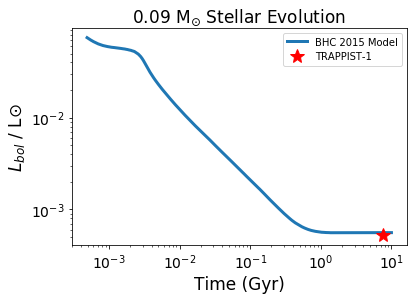

In [24]:
# Luminosity evolution: BHC 2015
figsize(6,4)
namez = ['M/Ms','log t(yr)','Teff','L/Ls','g','R/Rs','Log(Li/Li0)','log Tc','log ROc', 'Mrad', 'Rrad', 'k2conv', 'k2rad']
model = pd.read_csv(assorteddata + "BHAC15_tracks+structure.txt", dtype ='float',names = namez, skiprows=50, delim_whitespace=True)
idx = (model['M/Ms'] == 0.0900)
# L/Ls: log luminosity in units of solar luminosity (value used Ls=3.839d+33)
plot(np.power(10,model.loc[idx]['log t(yr)'].values) / 1e9, np.power(10,model.loc[idx]['L/Ls']),
     linewidth = 3, label = "BHC 2015 Model")
xlabel("Time (Gyr)", fontsize=17)
ylabel("$L_{bol}$ / L${\odot}$", fontsize=17)
xticks(fontsize=14)
yticks(fontsize=14)
plot(7.6, trappist_lum, markersize = 15, color = "Red", linestyle='None',marker="*", label="TRAPPIST-1")
yscale('log')
xscale("log")
legend()
title("Baraffe 2015, M = 0.09 Msun", fontsize=17)
title("0.09 M$_{\odot}$ Stellar Evolution", fontsize = 17)
savefig(paperFigures + "BHAC_stellarmodel.png",  dpi=150, bbox_inches = 'tight')

# Plot results from [VPlanet](https://github.com/VirtualPlanetaryLaboratory/vplanet) runs. 
We know ocean retention will depend on the XUV flux. 
To test how our derived XUV luminosity ratio affects the ocean evolution, we will run two integrations with VPlanet. We will also try running integrations with different values of Q, to see if that matters.

TODO: check d's habitable lcoation - why does it turn off?

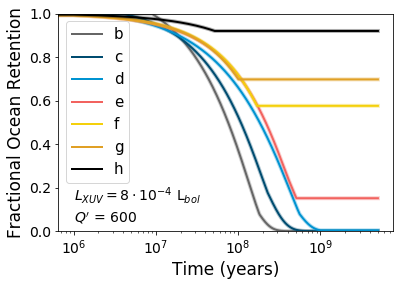

In [25]:
planets = ['b','c','d','e','f','g','h']
namz = ['Time','SurfWaterMass','OxygenMass','EnvelopeMass','ScaleHeight','SemiMajorAxis','DeccDtEqtide','EccTimeEqtide','EnvTidalQ','EnvK2']
figsize(6,4)
for i, planet in enumerate(planets):
    file_loc = current_dir + "VPlanetRuns/Results/run5/trappist1.%s.forward" % planet
    data = pd.read_csv(file_loc, names = namz, delim_whitespace=True)
    plot(data['Time'], data['SurfWaterMass'] / data['SurfWaterMass'].values[0], label='_nolegend_', linewidth = 4, alpha=0.3, c = colors_for_this[i])
    plot(data['Time'], data['SurfWaterMass'] / data['SurfWaterMass'].values[0], label=planet, linewidth = 2, c = colors_for_this[i])
xscale("log")
legend(fontsize=15)
xlabel("Time (years)", fontsize=17)
ylabel("Fractional Ocean Retention", fontsize=17)
yticks(fontsize=14)
xticks(fontsize=14)
ylim(0,1)
annotate("$L_{XUV} = 8 \cdot 10^{-4}$ L$_{bol}$\n$Q'$ = 600", (1e6, 0.05), fontsize = 14)
savefig(paperFigures + "trappist_water_midQ_trueLXUV.png", dpi=150, bbox_inches = 'tight')


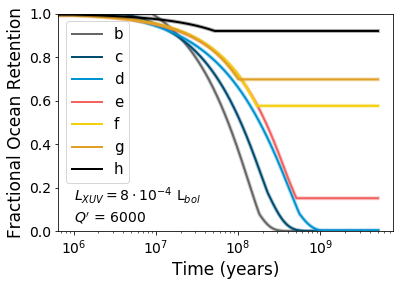

In [26]:
for i, planet in enumerate(planets):
    file_loc = current_dir + "VPlanetRuns/Results/run6/trappist1.%s.forward" % planet
    data = pd.read_csv(file_loc, names = namz, delim_whitespace=True)
    plot(data['Time'], data['SurfWaterMass'] / data['SurfWaterMass'].values[0], label='_nolegend_', linewidth = 4, alpha=0.3, c = colors_for_this[i])
    plot(data['Time'], data['SurfWaterMass'] / data['SurfWaterMass'].values[0], label=planet, linewidth = 2, c = colors_for_this[i])
xscale("log")
legend(fontsize=15)
xlabel("Time (years)", fontsize=17)
ylabel("Fractional Ocean Retention", fontsize=17)
yticks(fontsize=14)
xticks(fontsize=14)
ylim(0,1)
annotate("$L_{XUV} = 8 \cdot 10^{-4}$ L$_{bol}$\n$Q'$ = 6000", (1e6, 0.05), fontsize = 14)
savefig(extraFigures + "trappist_water_midQ_lowLXUV.png", dpi=150, bbox_inches = 'tight')


So, the value of Q (within our allowed range, at least) doesn't matter. 

However, TRAPPIST-1 is still strangely bright in the XUV. What if TRAPPIST-1 were a typical M8V? What would its ocean renention look like then?

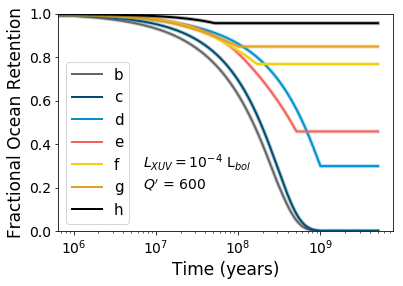

In [27]:
# Now check the results if the XUV is more typical for stars of this size / age / rotation rate. 
for i, planet in enumerate(planets):
    file_loc = current_dir + "VPlanetRuns/Results/run8/trappist1.%s.forward" % planet
    data = pd.read_csv(file_loc, names = namz, delim_whitespace=True)
    plot(data['Time'], data['SurfWaterMass'] / data['SurfWaterMass'].values[0], label='_nolegend_', linewidth = 4, alpha=0.3, c = colors_for_this[i])
    plot(data['Time'], data['SurfWaterMass'] / data['SurfWaterMass'].values[0], label=planet, linewidth = 2, c = colors_for_this[i])
xscale("log")
legend(fontsize=15)
xlabel("Time (years)", fontsize=17)
ylabel("Fractional Ocean Retention", fontsize=17)
yticks(fontsize=14)
xticks(fontsize=14)
ylim(0,1)
annotate("$L_{XUV} = 10^{-4}$ L$_{bol}$\n$Q'$ = 600", (7e6, 0.2), fontsize = 14)
savefig(paperFigures + "trappist_water_midQ_lowLXUV.png", dpi=150, bbox_inches = 'tight')


So only inner two planets would lose their oceans, instead of three, were TRAPPIST-1 more typical. There are additional factors to consider (such as replenishing water from the mantle, or the fact that VPlanet 'turns off' water loss rather than allowing it to continue once planet reaches habitable zone, or that you can define the habitable zone in different ways), so we do not make any claims about the true ocean rentention on these planets - only that Planer d is in a grey zone. 